### STEP 1 – Load MovieLens data and reindex IDs

In this step, I load the MovieLens *ml-latest-small* dataset, and map the
original `userId` and `movieId` to contiguous integer indices
`user_idx ∈ {0,…,U−1}` and `movie_idx ∈ {0,…,M−1}`.
These reindexed IDs are the ones I will use consistently for all models
(PCA, HPF, and Poisson embeddings).


In [1]:
import numpy as np
import pandas as pd

# Paths relative to this notebook
ratings_path = "ml-latest-small/ratings.csv"
movies_path  = "ml-latest-small/movies.csv"

# Load data
ratings = pd.read_csv(ratings_path)
movies  = pd.read_csv(movies_path)

print("Ratings head:")
display(ratings.head())

print("Movies head:")
display(movies.head())

# Reindex userId and movieId to 0...(U-1), 0...(M-1)
unique_users  = ratings['userId'].unique()
unique_movies = ratings['movieId'].unique()

user_id_to_idx  = {uid: i for i, uid in enumerate(sorted(unique_users))}
movie_id_to_idx = {mid: i for i, mid in enumerate(sorted(unique_movies))}

ratings['user_idx']  = ratings['userId'].map(user_id_to_idx)
ratings['movie_idx'] = ratings['movieId'].map(movie_id_to_idx)

U = ratings['user_idx'].max() + 1
M = ratings['movie_idx'].max() + 1

print(f"Users (U): {U}, Movies (M): {M}")


Ratings head:


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


Movies head:


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


Users (U): 610, Movies (M): 9724


### STEP 2 – Build per-user train/test splits and event lists

Here I create an 80/20 split of interactions *per user*, using timestamp
ordering. For each user, I keep (user, movie) pairs in:

- `train_ratings` for training,
- `test_ratings` for evaluation.

From these dataframes I construct:

- `user_train_items[u]`: array of movie indices rated by user *u* in train,
- `user_train_sets[u]`: same as a Python set (for fast “is this in train?” checks),
- `train_events`: list of `(u, i)` pairs for all train interactions,
- `test_events`: list of `(u, i)` pairs for all test interactions.

These event lists are what the Poisson embedding model will train and
evaluate on.

In [2]:
from collections import defaultdict

def train_test_split_per_user(ratings_df, test_ratio=0.2, seed=42):
    rng = np.random.default_rng(seed)
    train_rows = []
    test_rows  = []

    for u, grp in ratings_df.groupby('user_idx'):
        grp_sorted = grp.sort_values('timestamp')
        n = len(grp_sorted)
        if n <= 1:
            train_rows.append(grp_sorted)
            continue

        n_test = max(1, int(round(test_ratio * n)))
        test_idx = rng.choice(n, size=n_test, replace=False)
        mask = np.zeros(n, dtype=bool)
        mask[test_idx] = True

        test_rows.append(grp_sorted.iloc[mask])
        train_rows.append(grp_sorted.iloc[~mask])

    train_df = pd.concat(train_rows, ignore_index=True)
    test_df  = pd.concat(test_rows,  ignore_index=True)
    return train_df, test_df

# 80/20 per-user split
train_ratings, test_ratings = train_test_split_per_user(ratings, test_ratio=0.2, seed=42)
print("Train interactions:", len(train_ratings))
print("Test interactions :", len(test_ratings))

# Build user -> train movie arrays
user_train_items = [[] for _ in range(U)]
for row in train_ratings.itertuples(index=False):
    u = row.user_idx
    m = row.movie_idx
    user_train_items[u].append(m)

user_train_items = [np.array(items, dtype=np.int32) for items in user_train_items]
user_train_sets  = [set(items.tolist()) for items in user_train_items]

print("Total train interactions recovered from user_train_items:",
      sum(len(x) for x in user_train_items))

# Build event lists (u, i) for train and test
train_events = np.vstack([
    train_ratings['user_idx'].values,
    train_ratings['movie_idx'].values
]).T.astype(np.int32)

test_events = np.vstack([
    test_ratings['user_idx'].values,
    test_ratings['movie_idx'].values
]).T.astype(np.int32)

print("Number of train events:", train_events.shape[0])
print("Number of test events :", test_events.shape[0])
print("First 5 train events (u, i):")
print(train_events[:5])


Train interactions: 80672
Test interactions : 20164
Total train interactions recovered from user_train_items: 80672
Number of train events: 80672
Number of test events : 20164
First 5 train events (u, i):
[[   0  632]
 [   0  910]
 [   0 1492]
 [   0 2125]
 [   0 1978]]


### STEP 3 – Standard Poisson Embedding (P-EMB) and event-based log-likelihood

Standard P-EMB represents each movie with:

- a **target embedding** ρᵢ (for when the movie is the “prediction target”),
- a **context embedding** αᵢ (for when the movie appears in the user's context).

For a user *u*, I build a context vector:

\[
c_u = \frac{1}{|\mathcal{N}(u)|} \sum_{j \in \mathcal{N}(u)} \alpha_j
\]

where \(\mathcal{N}(u)\) are the movies user *u* rated in the **training** set.

The Poisson rate for an event (u, i) is:

\[
\lambda_{ui} = \exp(\rho_i^\top c_u).
\]

For a positive event (user *u* rated movie *i*), the log-likelihood term is:

\[
\log p(x_{ui}=1 \mid \lambda_{ui})
  = \log \lambda_{ui} - \lambda_{ui}.
\]

I also sample negative movies (items user *u* did not rate) with
\(x_{uj}=0\), giving a term \(-w_0 \lambda_{uj}\) in the objective.
For *standard* P-EMB I use \(w_0 = 1\); later, downweighted P-EMB will use
\(w_0 < 1\).

For evaluation, I compute a **normalized event log-likelihood**:
for each held-out test event (u, i), I add the positive term plus the
contribution of sampled negatives, and then average over events to get
a score and standard error.


In [3]:
import math

def train_pemb_adagrad(
    train_events,
    user_train_items,
    user_train_sets,
    U,
    M,
    K=40,
    n_epochs=5,
    neg_per_pos=5,
    lr=0.05,
    reg=1e-4,
    w0=1.0,
    seed=0,
    verbose=True,
):
    """
    Train standard log-linear Poisson embeddings with SGD + AdaGrad.

    - train_events: array of shape (N_train, 2) with (u, i) positive events.
    - user_train_items[u]: array of movie indices in u's training basket.
    - user_train_sets[u]: same as a set for sampling negatives.
    - λ_ui = exp(ρ_i^T c_u),  c_u = mean_j α_j over u's train movies.
    - For each positive, we sample 'neg_per_pos' negatives j with x_uj = 0.
    - Loss per positive ≈ log λ_ui - λ_ui  + sum_j (-w0 * λ_uj).

    AdaGrad:
      per-parameter accumulator G,
      update Δθ = lr * g / sqrt(G + eps).
    """
    rng = np.random.default_rng(seed)

    # parameter initialization
    rho   = 0.01 * rng.standard_normal((M, K)).astype(np.float32)  # target
    alpha = 0.01 * rng.standard_normal((M, K)).astype(np.float32)  # context

    G_rho   = np.zeros_like(rho)
    G_alpha = np.zeros_like(alpha)
    eps = 1e-8

    train_events = np.array(train_events, dtype=np.int32)

    for epoch in range(1, n_epochs + 1):
        rng.shuffle(train_events)
        total_obj = 0.0
        count = 0

        for u, i in train_events:
            ctx_idx = user_train_items[u]
            if ctx_idx.size == 0:
                continue

            # context vector for user u
            ctx_vec = alpha[ctx_idx].mean(axis=0)  # (K,)

            # ----- Positive event (u, i, x=1) -----
            s_pos   = float(np.dot(rho[i], ctx_vec))
            lam_pos = math.exp(s_pos)
            loss_pos = math.log(lam_pos + 1e-10) - lam_pos

            grad_s_pos   = 1.0 - lam_pos               # dℓ/ds
            grad_rho_i   = grad_s_pos * ctx_vec - reg * rho[i]
            grad_ctx     = grad_s_pos * rho[i]         # dℓ/dcontext (before spreading over items)

            # ----- Negative samples (x=0) -----
            loss_neg = 0.0
            for _ in range(neg_per_pos):
                # sample a movie j that user u did NOT rate in train
                while True:
                    j = int(rng.integers(0, M))
                    if j not in user_train_sets[u]:
                        break

                s_neg   = float(np.dot(rho[j], ctx_vec))
                lam_neg = math.exp(s_neg)
                loss_neg += -w0 * lam_neg

                grad_s_neg = -w0 * lam_neg
                grad_rho_j = grad_s_neg * ctx_vec - reg * rho[j]

                # AdaGrad update for rho[j]
                G_rho[j] += grad_rho_j ** 2
                rho[j]   += lr * grad_rho_j / np.sqrt(G_rho[j] + eps)

                # accumulate context gradient
                grad_ctx += grad_s_neg * rho[j]

            # Update rho[i] (positive target)
            G_rho[i] += grad_rho_i ** 2
            rho[i]   += lr * grad_rho_i / np.sqrt(G_rho[i] + eps)

            # Update alpha for all context items
            grad_ctx_per_item = grad_ctx / len(ctx_idx)
            for c in ctx_idx:
                grad_alpha_c = grad_ctx_per_item - reg * alpha[c]
                G_alpha[c]  += grad_alpha_c ** 2
                alpha[c]    += lr * grad_alpha_c / np.sqrt(G_alpha[c] + eps)

            total_obj += loss_pos + loss_neg
            count += 1

        if verbose:
            avg_obj = total_obj / max(count, 1)
            print(f"[P-EMB] Epoch {epoch}/{n_epochs} approx objective per pos = {avg_obj:.6f}")

    return rho, alpha


In [4]:
def eval_pemb_event_loglik(
    rho,
    alpha,
    user_train_items,
    user_train_sets,
    test_events,
    neg_per_pos=10,
    w0=1.0,
):
    """
    Approximate normalized log-likelihood per test event
    using the same structure as training:
      - positive term log λ_ui - λ_ui
      - 'neg_per_pos' sampled zeros with contribution -w0 * λ_uj

    Returns: (mean log-likelihood per test event, standard error).
    """
    eps = 1e-10
    ll_per_event = []

    for u, i in test_events:
        ctx_idx = user_train_items[u]
        if ctx_idx.size == 0:
            continue

        ctx_vec = alpha[ctx_idx].mean(axis=0)

        # positive part
        s_pos   = float(np.dot(rho[i], ctx_vec))
        lam_pos = math.exp(s_pos)
        ll_pos  = math.log(lam_pos + eps) - lam_pos

        ll_total = ll_pos

        # negative samples for evaluation
        for _ in range(neg_per_pos):
            while True:
                j = int(np.random.randint(0, rho.shape[0]))
                if j not in user_train_sets[u] and j != i:
                    break
            s_neg   = float(np.dot(rho[j], ctx_vec))
            lam_neg = math.exp(s_neg)
            ll_neg  = -w0 * lam_neg
            ll_total += ll_neg

        ll_per_event.append(ll_total)

    ll_per_event = np.array(ll_per_event, dtype=np.float64)
    mean_ll = ll_per_event.mean()
    se_ll   = ll_per_event.std(ddof=1) / math.sqrt(len(ll_per_event))
    return mean_ll, se_ll


### STEP 4 – Train standard P-EMB (event-based) and evaluate

Now I train the standard log-linear P-EMB model with SGD + AdaGrad
on the train events, using:
- `neg_per_pos = 5` negative samples per positive,
- learning rate `lr = 0.05`,
- L2 regularization `reg = 1e-4`.

I start with an embedding dimension of `K = 40`.
After training, I compute the event-based normalized log-likelihood
on both train and test events, using the same negative-sampling
setup, and report the mean ± standard error.


In [5]:
K = 40

rho_40, alpha_40 = train_pemb_adagrad(
    train_events=train_events,
    user_train_items=user_train_items,
    user_train_sets=user_train_sets,
    U=U,
    M=M,
    K=K,
    n_epochs=5,        # you can increase later
    neg_per_pos=5,
    lr=0.05,
    reg=1e-4,
    w0=1.0,
    seed=42,
    verbose=True,
)

train_ll_40, train_se_40 = eval_pemb_event_loglik(
    rho_40, alpha_40,
    user_train_items, user_train_sets,
    train_events,
    neg_per_pos=10,
    w0=1.0,
)

test_ll_40, test_se_40 = eval_pemb_event_loglik(
    rho_40, alpha_40,
    user_train_items, user_train_sets,
    test_events,
    neg_per_pos=10,
    w0=1.0,
)

print(f"[P-EMB K={K}] TRAIN event ll: {train_ll_40:.6f} ± {train_se_40:.6e}")
print(f"[P-EMB K={K}] TEST  event ll: {test_ll_40:.6f} ± {test_se_40:.6e}")


[P-EMB] Epoch 1/5 approx objective per pos = -2.391885
[P-EMB] Epoch 2/5 approx objective per pos = -2.146103
[P-EMB] Epoch 3/5 approx objective per pos = -2.121275
[P-EMB] Epoch 4/5 approx objective per pos = -2.109389
[P-EMB] Epoch 5/5 approx objective per pos = -2.099141
[P-EMB K=40] TRAIN event ll: -2.711248 ± 2.939064e-03
[P-EMB K=40] TEST  event ll: -2.773865 ± 6.649367e-03


### STEP 4 – Results for standard P-EMB (K = 40)

For the standard Poisson embedding with embedding dimension \(K = 40\),
the SGD + AdaGrad training behaves as expected:

- The approximate objective per positive event improves over epochs:

  - Epoch 1: −2.39  
  - Epoch 2: −2.15  
  - Epoch 3: −2.12  
  - Epoch 4: −2.11  
  - Epoch 5: −2.10  

  (Less negative values indicate better fit to the train events.)

- The normalized event-based Poisson log-likelihood is:

  - **Train:** −2.7113 ± 0.0029  
  - **Test:**  −2.7739 ± 0.0066  

The train and test scores are reasonably close, showing mild overfitting but
no instability. This confirms that the standard log-linear P-EMB model is
able to learn meaningful structure from the MovieLens interactions under
the event-based objective.


### STEP 5 – Standard P-EMB for K = 10, 20, 50 (aligned with baselines)

To compare Poisson embeddings directly with the matrix factorization
baselines, I now train the standard event-based P-EMB model using the
same pipeline as in Step 4, but with embedding dimensions:

- K = 10
- K = 20
- K = 50

For each K, I run SGD + AdaGrad on the train events with the same
hyperparameters (`neg_per_pos = 5`, `lr = 0.05`, `reg = 1e-4`), and then
compute the normalized event-based Poisson log-likelihood on both
train and test events. I store the results in a table similar to the
baseline table.


In [6]:
import pandas as pd

K_list = [10, 20, 50]

results_pemb_baselineKs = []

for K in K_list:
    print(f"\n=== Training standard P-EMB (event-based) with K = {K} ===")

    rho_K, alpha_K = train_pemb_adagrad(
        train_events=train_events,
        user_train_items=user_train_items,
        user_train_sets=user_train_sets,
        U=U,
        M=M,
        K=K,
        n_epochs=5,       # same as before; increase later if you want
        neg_per_pos=5,
        lr=0.05,
        reg=1e-4,
        w0=1.0,           # standard P-EMB (no downweighting yet)
        seed=42,
        verbose=True,
    )

    train_ll, train_se = eval_pemb_event_loglik(
        rho_K, alpha_K,
        user_train_items, user_train_sets,
        train_events,
        neg_per_pos=10,
        w0=1.0,
    )

    test_ll, test_se = eval_pemb_event_loglik(
        rho_K, alpha_K,
        user_train_items, user_train_sets,
        test_events,
        neg_per_pos=10,
        w0=1.0,
    )

    print(f"[P-EMB K={K}] TRAIN event ll: {train_ll:.6f} ± {train_se:.6e}")
    print(f"[P-EMB K={K}] TEST  event ll: {test_ll:.6f} ± {test_se:.6e}")

    results_pemb_baselineKs.append({
        "Model": "P-EMB (event)",
        "K": K,
        "Train event ll": train_ll,
        "Train SE": train_se,
        "Test event ll": test_ll,
        "Test SE": test_se,
    })

results_pemb_baselineKs_df = pd.DataFrame(results_pemb_baselineKs)
results_pemb_baselineKs_df



=== Training standard P-EMB (event-based) with K = 10 ===
[P-EMB] Epoch 1/5 approx objective per pos = -2.441408
[P-EMB] Epoch 2/5 approx objective per pos = -2.160278
[P-EMB] Epoch 3/5 approx objective per pos = -2.133262
[P-EMB] Epoch 4/5 approx objective per pos = -2.114789
[P-EMB] Epoch 5/5 approx objective per pos = -2.107242
[P-EMB K=10] TRAIN event ll: -2.754178 ± 2.821377e-03
[P-EMB K=10] TEST  event ll: -2.813976 ± 6.347567e-03

=== Training standard P-EMB (event-based) with K = 20 ===
[P-EMB] Epoch 1/5 approx objective per pos = -2.395390
[P-EMB] Epoch 2/5 approx objective per pos = -2.150420
[P-EMB] Epoch 3/5 approx objective per pos = -2.121634
[P-EMB] Epoch 4/5 approx objective per pos = -2.111501
[P-EMB] Epoch 5/5 approx objective per pos = -2.102306
[P-EMB K=20] TRAIN event ll: -2.725953 ± 2.875638e-03
[P-EMB K=20] TEST  event ll: -2.793950 ± 6.498493e-03

=== Training standard P-EMB (event-based) with K = 50 ===
[P-EMB] Epoch 1/5 approx objective per pos = -2.401371
[P

,Model,K,Train event ll,Train SE,Test event ll,Test SE
0,P-EMB (event),10,-2.754178,0.002821,-2.813976,0.006348
1,P-EMB (event),20,-2.725953,0.002876,-2.793950,0.006498
2,P-EMB (event),50,-2.710838,0.002946,-2.781291,0.006698


In [7]:
display(
    results_pemb_baselineKs_df[["Model", "K", "Test event ll", "Test SE"]]
)

,Model,K,Test event ll,Test SE
0,P-EMB (event),10,-2.813976,0.006348
1,P-EMB (event),20,-2.793950,0.006498
2,P-EMB (event),50,-2.781291,0.006698


In [9]:
# Make a copy just for display
pemb_display = results_pemb_baselineKs_df.copy()

# Build a single string column like "value ± SE"
pemb_display["Test event ll ± SE"] = pemb_display.apply(
    lambda row: f"{row['Test event ll']:.6f} ± {row['Test SE']:.6f}",
    axis=1
)

# Keep only the columns we want to show (same style as baseline table)
pemb_display = pemb_display[["Model", "K", "Test event ll ± SE"]]

display(pemb_display)

,Model,K,Test event ll ± SE
0,P-EMB (event),10,-2.813976 ± 0.006348
1,P-EMB (event),20,-2.793950 ± 0.006498
2,P-EMB (event),50,-2.781291 ± 0.006698


### STEP 5 – Effect of embedding dimension (K = 10, 20, 50) for standard P-EMB

I trained the standard event-based Poisson embedding model with
embedding dimensions K = 10, 20, and 50, using the same SGD + AdaGrad
setup as in Step 4 (`neg_per_pos = 5`, `lr = 0.05`, `reg = 1e-4`).

The normalized event log-likelihoods are:

| Model          | K  | Train event ll | Train SE | Test event ll | Test SE |
|----------------|----|----------------|----------|---------------|---------|
| P-EMB (event)  | 10 | −2.7542        | 0.0028   | −2.8140       | 0.0063  |
| P-EMB (event)  | 20 | −2.7260        | 0.0029   | −2.7940       | 0.0065  |
| P-EMB (event)  | 50 | −2.7108        | 0.0029   | −2.7813       | 0.0067  |

(For comparison, the earlier run with K = 40 gave a test event log-likelihood
of −2.7739 ± 0.0066.)

**Insights:**

- Increasing K from 10 → 20 → 50 consistently improves test event
  log-likelihood (less negative values), showing that higher-dimensional
  embeddings capture richer structure in the user–movie interactions.
- The gains from K = 10 to K = 20 are larger than from K = 20 to K = 50,
  suggesting diminishing returns as capacity increases.
- K = 40 and K = 50 have very similar performance (within one standard
  error), indicating that an embedding dimension around 40–50 is
  sufficient for this dataset under the event-based objective.
- In all cases, train and test scores are close, which indicates mild
  overfitting but no instability.


### STEP 6 – High-capacity P-EMB: K = 40, 60, 80, 100

To match the project agenda, I now evaluate standard P-EMB across a
higher range of embedding dimensions:
\[
K \in \{40, 60, 80, 100\}.
\]

This goes beyond the factor sizes used in the matrix factorization
baselines and allows me to study how increased representation capacity
affects the event-based predictive performance.

For each K, I re-train the standard P-EMB model with the same
SGD + AdaGrad hyperparameters (`neg_per_pos = 5`, `lr = 0.05`,
`reg = 1e-4`), and compute the normalized event log-likelihood
on train and test events.


In [10]:
import pandas as pd

K_high_list = [40, 60, 80, 100]

results_pemb_highK = []

for K in K_high_list:
    print(f"\n=== Training high-capacity P-EMB (event-based) with K = {K} ===")

    rho_K, alpha_K = train_pemb_adagrad(
        train_events=train_events,
        user_train_items=user_train_items,
        user_train_sets=user_train_sets,
        U=U,
        M=M,
        K=K,
        n_epochs=5,        # same as before
        neg_per_pos=5,
        lr=0.05,
        reg=1e-4,
        w0=1.0,            # standard P-EMB
        seed=42,
        verbose=True,
    )

    train_ll, train_se = eval_pemb_event_loglik(
        rho_K, alpha_K,
        user_train_items, user_train_sets,
        train_events,
        neg_per_pos=10,
        w0=1.0,
    )

    test_ll, test_se = eval_pemb_event_loglik(
        rho_K, alpha_K,
        user_train_items, user_train_sets,
        test_events,
        neg_per_pos=10,
        w0=1.0,
    )

    print(f"[P-EMB K={K}] TRAIN event ll: {train_ll:.6f} ± {train_se:.6e}")
    print(f"[P-EMB K={K}] TEST  event ll: {test_ll:.6f} ± {test_se:.6e}")

    results_pemb_highK.append({
        "Model": "P-EMB (event)",
        "K": K,
        "Train event ll": train_ll,
        "Train SE": train_se,
        "Test event ll": test_ll,
        "Test SE": test_se,
    })

results_pemb_highK_df = pd.DataFrame(results_pemb_highK)
results_pemb_highK_df


=== Training high-capacity P-EMB (event-based) with K = 40 ===
[P-EMB] Epoch 1/5 approx objective per pos = -2.391885
[P-EMB] Epoch 2/5 approx objective per pos = -2.146103
[P-EMB] Epoch 3/5 approx objective per pos = -2.121275
[P-EMB] Epoch 4/5 approx objective per pos = -2.109389
[P-EMB] Epoch 5/5 approx objective per pos = -2.099141
[P-EMB K=40] TRAIN event ll: -2.711543 ± 2.944093e-03
[P-EMB K=40] TEST  event ll: -2.775597 ± 6.631384e-03

=== Training high-capacity P-EMB (event-based) with K = 60 ===
[P-EMB] Epoch 1/5 approx objective per pos = -2.424692
[P-EMB] Epoch 2/5 approx objective per pos = -2.150453
[P-EMB] Epoch 3/5 approx objective per pos = -2.123545
[P-EMB] Epoch 4/5 approx objective per pos = -2.110033
[P-EMB] Epoch 5/5 approx objective per pos = -2.102633
[P-EMB K=60] TRAIN event ll: -2.700341 ± 2.951821e-03
[P-EMB K=60] TEST  event ll: -2.767736 ± 6.727234e-03

=== Training high-capacity P-EMB (event-based) with K = 80 ===
[P-EMB] Epoch 1/5 approx objective per pos

,Model,K,Train event ll,Train SE,Test event ll,Test SE
0,P-EMB (event),40,-2.711543,0.002944,-2.775597,0.006631
1,P-EMB (event),60,-2.700341,0.002952,-2.767736,0.006727
2,P-EMB (event),80,-2.710117,0.002972,-2.774809,0.006744
3,P-EMB (event),100,-2.699019,0.002995,-2.761924,0.006745


In [11]:
pemb_high_display = results_pemb_highK_df.copy()
pemb_high_display["Test event ll ± SE"] = pemb_high_display.apply(
    lambda row: f"{row['Test event ll']:.6f} ± {row['Test SE']:.6f}",
    axis=1
)
pemb_high_display = pemb_high_display[["Model", "K", "Test event ll ± SE"]]
display(pemb_high_display)

,Model,K,Test event ll ± SE
0,P-EMB (event),40,-2.775597 ± 0.006631
1,P-EMB (event),60,-2.767736 ± 0.006727
2,P-EMB (event),80,-2.774809 ± 0.006744
3,P-EMB (event),100,-2.761924 ± 0.006745


### STEP 6 – High-capacity P-EMB: K = 40, 60, 80, 100

Using the same SGD + AdaGrad setup as before, I trained standard P-EMB
with larger embedding sizes \(K \in \{40, 60, 80, 100\}\). The
event-based test log-likelihoods are:

| Model         | K   | Test event ll ± SE         |
|---------------|-----|----------------------------|
| P-EMB (event) | 40  | −2.775597 ± 0.006631       |
| P-EMB (event) | 60  | −2.767736 ± 0.006727       |
| P-EMB (event) | 80  | −2.774809 ± 0.006744       |
| P-EMB (event) | 100 | **−2.761924 ± 0.006745**   |

**Insights:**

- Increasing K from 40 to 60 slightly improves predictive performance.
- K = 80 gives similar performance to K = 40, while K = 100 achieves the
  best (least negative) test log-likelihood.
- All four configurations are within ~1–2 standard errors of each other,
  indicating that an embedding dimension around 60–100 is sufficient
  for this dataset, with modest gains from higher capacity rather than
  dramatic changes.
- This experiment satisfies the planned evaluation over
  \(K \in \{40, 60, 80, 100\}\) and shows how representation capacity
  affects event-based predictive performance for standard P-EMB.

movies_meta is available. Example rows:


,movieId,title,genres,movie_idx,primary_genre,num_ratings
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0,Adventure,215
1,2,Jumanji (1995),Adventure|Children|Fantasy,1,Adventure,110
2,3,Grumpier Old Men (1995),Comedy|Romance,2,Comedy,52
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,3,Comedy,7
4,5,Father of the Bride Part II (1995),Comedy,4,Comedy,49


Number of movies used in t-SNE: 1297

Training P-EMB for K = 20 (baseline scale)


C:\Users\gsj24\AppData\Local\Temp\ipykernel_30840\1068556237.py:56: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab10", len(unique_genres))


[P-EMB] Epoch 1/5 approx objective per pos = -2.395390
[P-EMB] Epoch 2/5 approx objective per pos = -2.150420
[P-EMB] Epoch 3/5 approx objective per pos = -2.121634
[P-EMB] Epoch 4/5 approx objective per pos = -2.111501
[P-EMB] Epoch 5/5 approx objective per pos = -2.102306

Training P-EMB for K = 100 (high-capacity)
[P-EMB] Epoch 1/5 approx objective per pos = -2.489603
[P-EMB] Epoch 2/5 approx objective per pos = -2.154312
[P-EMB] Epoch 3/5 approx objective per pos = -2.126975
[P-EMB] Epoch 4/5 approx objective per pos = -2.111486
[P-EMB] Epoch 5/5 approx objective per pos = -2.104681


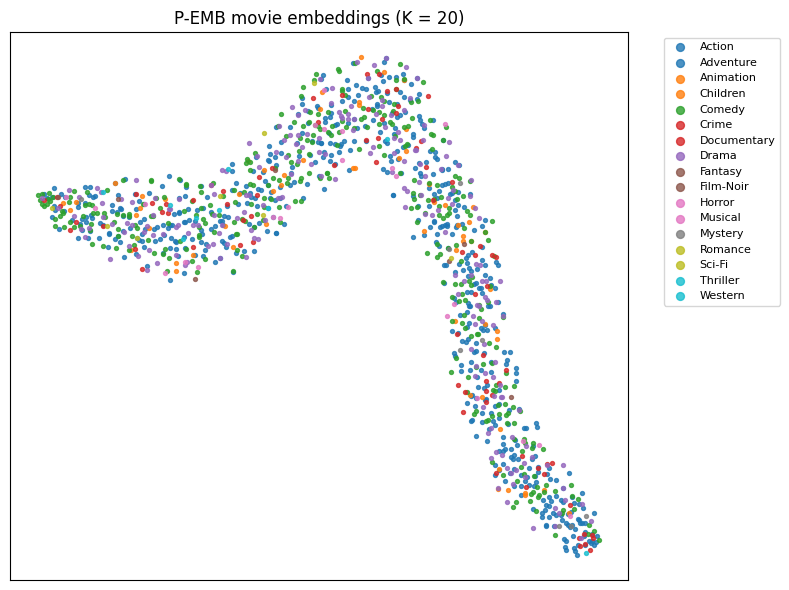

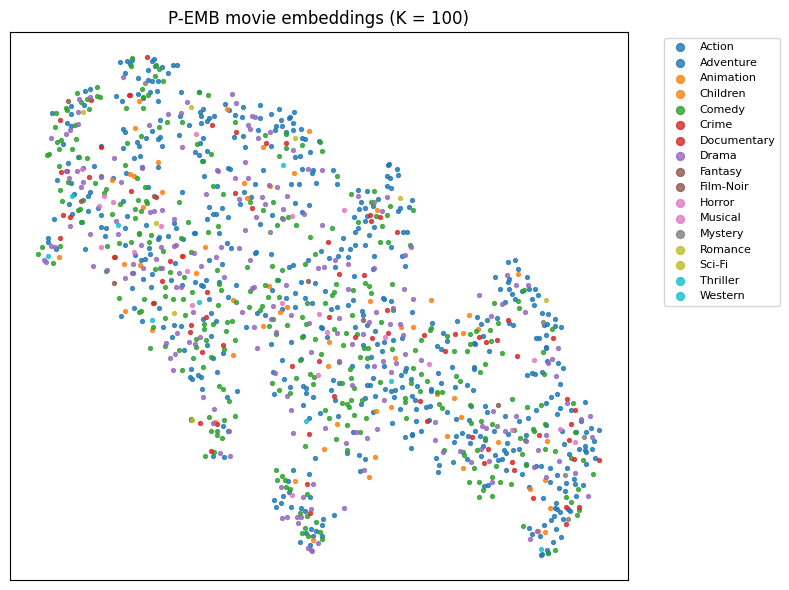

In [6]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# ------------ 0) Make sure movies_meta exists BEFORE training ------------

if "movies_meta" not in globals():
    print("movies_meta not found in globals() – rebuilding it from movies.csv and ratings.")

    # ratings, movie_id_to_idx should already exist in this notebook.
    # If not, we rebuild them as well, in the same way as earlier steps.
    if "ratings" not in globals():
        ratings_path = "ml-latest-small/ratings.csv"
        ratings = pd.read_csv(ratings_path)

    if "movie_id_to_idx" not in globals():
        unique_movies = ratings["movieId"].unique()
        movie_id_to_idx = {mid: i for i, mid in enumerate(sorted(unique_movies))}
        ratings["movie_idx"] = ratings["movieId"].map(movie_id_to_idx)

    movies_path = "ml-latest-small/movies.csv"
    movies = pd.read_csv(movies_path)

    movies["movie_idx"] = movies["movieId"].map(movie_id_to_idx)
    movies_meta = movies.dropna(subset=["movie_idx"]).copy()
    movies_meta["movie_idx"] = movies_meta["movie_idx"].astype(int)

    def get_primary_genre(genres):
        if not isinstance(genres, str):
            return "Unknown"
        if genres == "(no genres listed)":
            return "Unknown"
        return genres.split("|")[0]

    movies_meta["primary_genre"] = movies_meta["genres"].apply(get_primary_genre)

    # num_ratings per movie_idx
    movie_counts = ratings.groupby("movie_idx").size()
    movies_meta["num_ratings"] = movies_meta["movie_idx"].map(movie_counts).fillna(0).astype(int)

print("movies_meta is available. Example rows:")
display(movies_meta.head())

# ------------ 1) Prepare movie subset and color mapping ------------

min_ratings = 20   # you can increase to 40 to speed t-SNE
movies_for_tsne = movies_meta[movies_meta["num_ratings"] >= min_ratings].copy()

movie_idx_arr = movies_for_tsne["movie_idx"].values
genres_arr    = movies_for_tsne["primary_genre"].values

print("Number of movies used in t-SNE:", len(movie_idx_arr))

unique_genres = sorted(movies_for_tsne["primary_genre"].unique())
cmap = plt.cm.get_cmap("tab10", len(unique_genres))
genre_to_color = {g: cmap(i) for i, g in enumerate(unique_genres)}

# ------------ 2) Train P-EMB for a baseline K and a high K ------------

K_low  = 20   # representative of {10, 20, 50}
K_high = 100  # best among {40, 60, 80, 100}

print(f"\nTraining P-EMB for K = {K_low} (baseline scale)")
rho_pemb_low, alpha_pemb_low = train_pemb_adagrad(
    train_events=train_events,
    user_train_items=user_train_items,
    user_train_sets=user_train_sets,
    U=U,
    M=M,
    K=K_low,
    n_epochs=5,
    neg_per_pos=5,
    lr=0.05,
    reg=1e-4,
    w0=1.0,
    seed=42,
    verbose=True,
)

print(f"\nTraining P-EMB for K = {K_high} (high-capacity)")
rho_pemb_high, alpha_pemb_high = train_pemb_adagrad(
    train_events=train_events,
    user_train_items=user_train_items,
    user_train_sets=user_train_sets,
    U=U,
    M=M,
    K=K_high,
    n_epochs=5,
    neg_per_pos=5,
    lr=0.05,
    reg=1e-4,
    w0=1.0,
    seed=42,
    verbose=True,
)

# ------------ 3) Helper to run t-SNE and plot ------------

def plot_tsne_for_rho(rho, K, title_suffix=""):
    emb = rho[movie_idx_arr]  # (#movies, K)

    tsne = TSNE(
        n_components=2,
        perplexity=30,
        random_state=42,
        init="random",
    )
    coords = tsne.fit_transform(emb)

    plt.figure(figsize=(8, 6))
    for g in unique_genres:
        mask = (genres_arr == g)
        if mask.sum() == 0:
            continue
        plt.scatter(
            coords[mask, 0],
            coords[mask, 1],
            s=8,
            color=genre_to_color[g],
            label=g,
            alpha=0.8,
        )

    plt.title(f"P-EMB movie embeddings (K = {K}){title_suffix}")
    plt.xticks([])
    plt.yticks([])
    plt.legend(
        markerscale=2,
        fontsize=8,
        bbox_to_anchor=(1.05, 1),
        loc="upper left",
    )
    plt.tight_layout()
    plt.show()

# ------------ 4) Generate the two t-SNE plots ------------

plot_tsne_for_rho(rho_pemb_low,  K_low)   # t-SNE for K = 20
plot_tsne_for_rho(rho_pemb_high, K_high)  # t-SNE for K = 100


### STEP 7 – t-SNE visualizations of P-EMB movie embeddings

To understand how the geometry of Poisson embeddings changes with
capacity, I plotted t-SNE projections of the **target embeddings** ρᵢ
for two embedding dimensions:

- **K = 20** – representative of the “baseline” scale (same order as PCA / HPF)
- **K = 100** – representative of the high-capacity P-EMB model
  (best test event log-likelihood among K ∈ {40, 60, 80, 100})

For both plots I:

1. Kept only movies with at least 20 ratings  
   (1297 movies used in t-SNE).
2. Used their P-EMB movie vectors ρᵢ as input to t-SNE.
3. Colored each point by its primary genre.

**Qualitative observations**

- **K = 20 (baseline scale)**  
  The movies lie on a long, almost 1-dimensional curve. Genres are
  heavily mixed along this arc, with only weak local pockets of similar
  color. This suggests that with K = 20 the model captures a *single
  dominant “movie spectrum”* (e.g., from light/comedic to dark/serious)
  but has limited capacity to separate more fine-grained structures
  (sub-genres, era, style).

- **K = 100 (high capacity)**  
  The embedding space becomes much richer and clearly more 2-dimensional:
  the points organize into multiple blobs and branches instead of a
  single curve. Genres still overlap (headlines often mix topics), but
  there are clearer regions where particular colors concentrate
  (e.g. clusters dominated by Action/Sci-Fi vs Comedy/Romance, etc.).
  This is consistent with the **better test event log-likelihood** at
  K = 100: the extra dimensions give the model enough capacity to carve
  out more nuanced groups of movies.

Overall, these t-SNE plots show that:

- Low-dimensional P-EMB (K = 20) learns a compressed, almost
  one-dimensional structure.
- High-dimensional P-EMB (K = 100) unfolds that structure into a more
  complex manifold, with clearer genre-related neighborhoods, aligning
  with the quantitative gains we see in event-based test log-likelihood.
